In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import matplotlib.pyplot as plt

In [3]:
from PIL import Image

In [4]:
import sys
sys.path.append("../figures")

from where_copie import RetinaFill, CollFill, WhereShift, RetinaBackground, RetinaMask, RetinaWhiten, TransformDico
from where_copie import RetinaTransform, WhereNet, CollTransform, MNIST, Normalize, WhereTrainer, Where

In [5]:
from main import init
args = init(filename='../data/2019-06-13')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-13',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True}

In [6]:
from retina_copie import Retina
retina = Retina(args)

../tmp/retina_6_24_10_2_1.41_128_dico.npy
Fichier retina_dico charge avec succes
../tmp/colliculus_transform_6_24_10_2_1.41_128_dico.npy
Fichier colliculus_transform_dico charge avec succes
../tmp/retina_6_24_10_2_1.41_128_transform.npy
Fichier retina_transform charge avec succes
../tmp/retina_6_24_10_2_1.41_128_inverse_transform.npy
Fichier retina_inverse_transform charge avec succes
[[[[[-1.34578012e-06 -3.61608946e-07  2.47846366e-07 ...
     -1.58394164e-06 -1.79136210e-07  9.81529407e-07]
    [ 1.94262472e-07  1.10002683e-06 -1.43906817e-07 ...
      1.35489608e-06  1.88248271e-07 -1.03068022e-06]]

   [[ 2.55215728e-07 -2.99334069e-08  4.06034924e-07 ...
      2.30432812e-07  4.23618784e-07 -3.24925703e-07]
    [ 1.17865301e-07 -1.71997077e-07 -3.67099262e-08 ...
     -3.38753978e-07  2.27816179e-07  1.60090087e-07]]

   [[ 4.00914200e-13 -2.41069660e-13 -9.14516934e-14 ...
     -5.82631433e-13 -8.26267722e-14  3.85662760e-13]
    [ 5.25926110e-13  6.18874688e-13 -4.02616641e-13 

     -1.37007717e-01 -1.50591396e-01 -1.62652149e-01]]]]]


In [7]:
accuracy_map = np.loadtxt('../dev/AccuracyMap_MNIST_cnn_robust_what_0.1_0.1_1_0.7_60epoques_2019-06-12_16h11.txt', max_rows=55)

In [8]:
accuracy_map.min()

0.0565

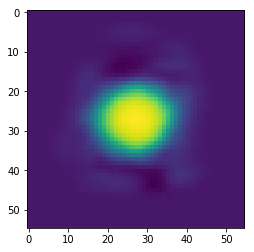

In [9]:
plt.imshow(accuracy_map)

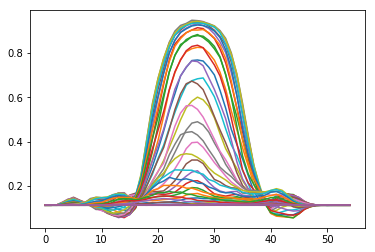

In [10]:
_ = plt.plot(accuracy_map)

## Unit tests

In [11]:
import math

In [12]:
i_offset = -18 #None #
j_offset = 18 #None #

In [13]:
args.contrast = 0.5

In [14]:
transform=transforms.Compose([
                               RetinaFill(N_pic=args.N_pic),
                               #WhereShift(args, theta=3*math.pi/4), 
                               #WhereShift(args, radius = 18), 
                               WhereShift(args, i_offset=i_offset, j_offset=j_offset),
                               RetinaBackground( contrast=args.contrast,
                                                 noise=args.noise,
                                                 sf_0=args.sf_0,
                                                 B_sf=args.B_sf),
                               RetinaMask(N_pic=args.N_pic),
                               RetinaWhiten(N_pic=args.N_pic),
                               TransformDico(retina),
                               #Normalize()
                           ])

In [15]:
target_transform=transforms.Compose([
                               CollFill(accuracy_map=accuracy_map, N_pic=args.N_pic),
                               #WhereShift(args, theta=3*math.pi/4, baseline = 0.1),
                               #WhereShift(args, radius = 18, baseline = 0.1),
                               WhereShift(args, i_offset=i_offset, j_offset=j_offset, baseline = 0.1),
                               CollTransform(retina.colliculus_transform_vector),
                           ])

In [16]:
dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        #target_transform = target_transform,
                        )

In [17]:
len(dataset_train)

60000

In [18]:
train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [19]:
dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        #target_transform = target_transform,
                        )

In [20]:
len(dataset_test)

10000

In [21]:
test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [25]:
import datetime
debut = datetime.datetime.now()

liste, label = next(iter(train_loader))
image = liste[0]
features = liste[1]

fin = datetime.datetime.now()
print("Duree d'execution", fin-debut)

Duree d'execution 0:00:15.849628


In [26]:
image.shape

torch.Size([100, 128, 128])

In [27]:
features.shape

torch.Size([100, 2880])

In [28]:
print(features[0])

tensor([-0.1775, -0.4613, -0.3605,  ...,  0.9327, -0.3333,  1.1303],
       dtype=torch.float64)


In [29]:
label.shape

torch.Size([100])

## Test entraînement réseau

In [ ]:
if False :
    import sys
    sys.path.append("../figures")

    from where_copie import RetinaFill, CollFill, WhereShift, RetinaBackground, RetinaMask, RetinaWhiten 
    from where_copie import RetinaTransform, WhereNet, CollTransform, MNIST, Normalize, WhereTrainer, Where

    from main import init
    args = init(filename='../data/2019-06-12')

    args.epochs = 1
    args.save_model = True

    where = Where(args)

In [ ]:
if False : where.test()

## Zone expérimentale

#### Attribut dico

In [ ]:
if False :
    retina_dico = np.load("../tmp/retina_6_24_10_2_1.41_128_dico.npy")
    print(retina_dico.shape)
    

array = np.asarray([0,1,2])
print(array.shape)

In [ ]:
class RetinaTest:
    def __init__(self):
        self.init_retinatest_dico()
    def init_retinatest_dico(self):
        self.retinatest_dico = {}
        print(len(self.retinatest_dico))
        for i in range(3):
            self.retinatest_dico[i] = {}
            print(len(self.retinatest_dico))
            for j in range(3,6):
                self.retinatest_dico[i][j] = [2*j, 3*j, 4*j]
                

In [ ]:
retinaTest = RetinaTest()

In [ ]:
print(retinaTest.retinatest_dico)

In [ ]:
print(retinaTest.retinatest_dico[1][4][2])

In [ ]:
print(len(retinaTest.retinatest_dico))